# CSI 5139 F00: Assignment 3

# content

[1. Data Preparation](#Data_Preparation_Part)

- [1.1 Provided](#Provided)

- [1.2 Provided](#Provided)

[2. Model Design (7 layers)](#model_design)

- [2.1 Model structure](#model_structure)

- [2.2 Train the model](#train_the_model)

- [2.3 Evaluate the model](#evaluate_the_model)

[2. VGG16 transfer learning](#vgg16_transfer_learning)

- [2.1 Get all data sets](#get_all_data_sets)




<a id='Data_Preparation_Part'></a>

# 1. Data Preparation

<a id='Provided'></a>

## 1.1 Provided by the assignment start

_This notebook contains simple starter code to show loading and displaying a pair of test images and the associated flow._

In [1]:
# Adapted helper routine from Aurelien Geron: Hand-on Machine Learning with Scikit-learn & Tensorflow.

# Common imports
import numpy as np
import os
import skimage 

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "./"
NB_ID = "assignment3"

# create the directory if it does not exist
os.makedirs(os.path.join(PROJECT_ROOT_DIR, "images", NB_ID), exist_ok = True)
        
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", NB_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

/home/azhang/.local/lib/python3.5/site-packages/matplotlib/__init__.py:1038: UserWarning: Bad val "GTKAgg" on line #1
	"backend: GTKAgg
"
	in file "/home/azhang/.config/matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string 'gtkagg': valid strings are ['Qt5Cairo', 'WX', 'Qt4Agg', 'Qt4Cairo', 'TkCairo', 'Qt5Agg', 'WXCairo', 'pdf', 'MacOSX', 'WebAgg', 'nbAgg', 'cairo', 'template', 'WXAgg', 'pgf', 'svg', 'GTK3Cairo', 'GTK3Agg', 'ps', 'agg', 'TkAgg']
  (val, error_details, msg))


Let's load the image pairs and the corresponding flow 

In [2]:
train_images = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'rot_images_train.npy'))

In [3]:
train_flows = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'rot_flows_train.npy'))

In [4]:
print('Size of training images: {0} x {1} x {2} x {3}\n'.format(*train_images.shape))
print('Size of flow results: {0} x {1} x {2} x {3}\n'.format(*train_flows.shape))

Size of training images: 1860 x 6 x 64 x 64

Size of flow results: 1860 x 4 x 64 x 64



For RGB images, we need the channels last, e.g., 64x64x3.

In [5]:
def make_RGB(img_arr, img_no, seq_no ): 
    test = np.zeros(img_arr.shape[2:]+(3,))  
    test[:,:,2] = img_arr[img_no,0+3*seq_no,:,:] 
    test[:,:,1] = img_arr[img_no,1+3*seq_no,:,:] 
    test[:,:,0] = img_arr[img_no,2+3*seq_no,:,:]
    return test

In [6]:
def make_Greyscale(img_arr, img_no, seq_no ): 
    return img_arr[img_no,seq_no,:,:] 

Saving figure example_data


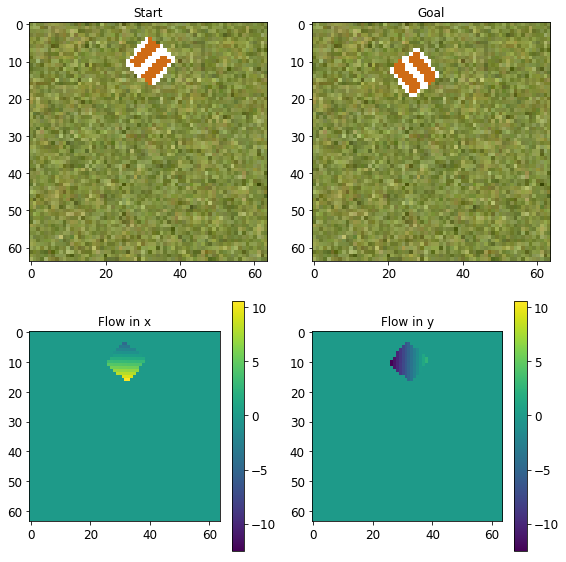

In [7]:
img_num = 100

fig, axes = plt.subplots(2, 2,figsize=(8,8))
axes[0, 0].imshow(make_RGB(train_images, img_num, 0 ))
axes[0, 0].set_title('Start')    

axes[0, 1].imshow(make_RGB(train_images, img_num, 1 ))
axes[0, 1].set_title('Goal')    

# Find the min and max of the flow.
from matplotlib import colors
fl_min = np.min(train_flows[img_num,0:2,:,:])
fl_max = np.max(train_flows[img_num,0:2,:,:])
fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

im = axes[1, 0].imshow(make_Greyscale(train_flows, img_num, 0 ))
im.set_norm(fl_norm)
axes[1, 0].set_title('Flow in x')
fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(make_Greyscale(train_flows, img_num, 1 ))
im.set_norm(fl_norm)
axes[1, 1].set_title('Flow in y')
fig.colorbar(im,ax=axes[1, 1])

save_fig("example_data")


Since all the train images and flows are already extracted out, we here get another $2$ necessary sets for the test.

In [8]:
test_images = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'rot_images_test.npy'))
test_flows = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'rot_flows_test.npy'))

<a id='tramsfer_the_format'></a>

## 1.2 Transfer the format

Here, all pairs of images (start and goal) are concatenated through the RGB channels into size $(64, 64, 6)$. And all pairs of ground truth labels (flow in x and y) are concatenated into size $(64, 64, 2)$.

Note that, experimentally, concatenating data through last axis may be a good way for the model to learn.

In [9]:
def GetInputSet(raw_images, concat_last_axis = True):
    """
    Function: concatenate each pair images together as input.
    """
    hm_images = len(raw_images)
    dataset = []
    for i in range(hm_images):
        img_start = make_RGB(raw_images, i, 0)
        img_goal = make_RGB(raw_images, i, 1)
        # concatenate on the last dimension
        if concat_last_axis:
            imgs_concat = np.concatenate([img_start, img_goal], axis = -1)
        else:
            imgs_concat = np.concatenate([img_start, img_goal], axis = 0)
        dataset.append(imgs_concat)
    dataset = np.array(dataset)
    return dataset

def GetOutputset(raw_gts, concat_last_axis = True):
    """
    Function: get the corresponding ground truth vectors.
    """
    hm_gts = len(raw_gts)
    dataset = []
    for i in range(hm_gts):
        # expand the last dimension for concatenating
        gt_x = np.expand_dims(make_Greyscale(raw_gts, i, 0), axis=-1)
        gt_y = np.expand_dims(make_Greyscale(raw_gts, i, 1), axis=-1)
        # concatenate on the last dimension
        if concat_last_axis:
            gt_concat = np.concatenate([gt_x, gt_y], axis = -1)
        else:
            gt_concat = np.concatenate([gt_x, gt_y], axis = 0)
        dataset.append(gt_concat)
    dataset = np.array(dataset)
    return dataset

And, of cause, before training, all data are shuffled.

In [10]:
def ShuffleIndex(data):
    """
    Function: return shuffled index
    """
    shuffle_index = np.arange(len(data))
    np.random.seed(100010)
    np.random.shuffle(shuffle_index)
    return shuffle_index

def Shuffle(data_in, data_out):
    """
    Function: shuffle dataset
    """
    shuffle_index = ShuffleIndex(data_in)
    data_in = data_in[shuffle_index]
    data_out = data_out[shuffle_index]
    return data_in, data_out

train_in = GetInputSet(train_images)
train_out = GetOutputset(train_flows)
train_in, train_out = Shuffle(train_in, train_out)

test_in = GetInputSet(test_images)
test_out = GetOutputset(test_flows)

print("Shape of the training images:\t", train_in.shape)
print("Shape of the training flows:\t",train_out.shape)
print("Shape of the test images:\t",test_in.shape)
print("Shape of the test flows:\t",test_out.shape)

Shape of the training images:	 (1860, 64, 64, 6)
Shape of the training flows:	 (1860, 64, 64, 2)
Shape of the test images:	 (444, 64, 64, 6)
Shape of the test flows:	 (444, 64, 64, 2)


<a id='model_design'></a>

# 2. Model design (7 layers)

<a id='model_structure'></a>

## 2.1 Model structure

Four convolutional layers are built for learning the features of the image, then 2 deconvolutional layers are used for sizing back the feature maps to the flow image size.

Loss function is designed based on mean square error, since the best way to learn the localization problems is MSE. 

Metrics function is defined by calculating the $l_1$ norm between prediction and ground truth. Then a threshold is set as $3e-3$ to filter the results. Specially, when the $l_1$ norm is less than the threshold, it will be set as the right prediction. Then, the number of the right predicition pixels are divided by the total number of pixels to get the accuracy.

Details is printed out at the end.

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# import tf.keras
import tensorflow.keras.backend as K
K.clear_session()
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
import tensorflow.keras.regularizers as R
from tensorflow.keras.optimizers import Adam

def Loss(y_true, y_pred):
    """
    Loss Function: use the MSE principle.
    """
    weight_vector = tf.where(y_true==0., 0.2*K.ones_like(y_true), 0.8*K.ones_like(y_true))
    # return K.mean(K.square(y_true - y_pred)*weight_vector)
    return K.mean(K.square(y_pred - y_true))

def Metrics(y_true, y_pred):
    """
    Metrics Function: set if the difference between prediction and 
    ground truth is less than 3e-3, set it as right prediction. 
    Then calculate the total number of the right predictions out of 
    the whole flow image.
    """
    # weight_vector = tf.where(y_true==0., 0.2*K.ones_like(y_true), 0.8*K.ones_like(y_true))
    value = K.abs(y_true - y_pred)
    false_pred = K.cast(K.greater(value, 3.e-3), 'float32') # * weight_vector
    whole_ones = K.ones_like(value) # * weight_vector
    return K.sum(1. - false_pred) / K.sum(whole_ones)

K.clear_session()

model = Sequential()
model.add(L.Conv2D(64, (3, 3), strides=(1, 1), padding='same', \
                   activation='relu', input_shape=(64, 64, 6)))
model.add(L.Conv2D(128, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu'))
model.add(L.Conv2D(256, (3, 3), strides=(1, 1), padding='same', \
                   activation='relu'))
model.add(L.Conv2D(512, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu'))
model.add(L.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu'))
model.add(L.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu'))
model.add(L.Conv2D(2, (3, 3), strides=(1, 1), padding='same', \
                   activation='linear'))

model.summary()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3520      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       1180160   
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       1179904   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 2)         2306      
Total para

<a id='train_the_model'></a>

## 2.2 Train the model

Some parameters are set as:
1. learning rate = $0.0008$;
2. learning rate decay rate = $0.8$;
3. batch size = $10$;
4. total epochs = $15$.

In [12]:
# GPU memory management
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, min_lr=1e-5)
model.compile(loss=Loss, optimizer=Adam(lr=0.0008), metrics=[Metrics])

model.fit(train_in, train_out, batch_size=10, epochs=10,
#             validation_data=(test_in, test_out),
            callbacks=[reduce_lr])

Epoch 1/10
1860/1860 [==============================] - 11s 6ms/step - loss: 0.4929 - Metrics: 0.1870
Epoch 2/10
1860/1860 [==============================] - 8s 4ms/step - loss: 0.2323 - Metrics: 0.2187
Epoch 3/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.1625 - Metrics: 0.2640
Epoch 4/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.1183 - Metrics: 0.2783
Epoch 5/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0915 - Metrics: 0.2361
Epoch 6/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0758 - Metrics: 0.2298
Epoch 7/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0619 - Metrics: 0.2470
Epoch 8/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0550 - Metrics: 0.2450
Epoch 9/10
1860/1860 [==============================] - 8s 4ms/step - loss: 0.0467 - Metrics: 0.2937
Epoch 10/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0406 - Metr

<a id='evaluate_the_model'></a>

## 2.3 Evaluate the model

The model is then evaluated on the test set.

In [13]:
results = model.evaluate(test_in, test_out)
print("The accuracy on test set is: \t", results[1])

444/444 [==============================] - 1s 2ms/step
The accuracy on test set is: 	 0.1628412468744828


In order the make the results more intuitive, a random pair of images are selected out and the prediction of the pair with the ground truth labels are plotted at the end of the cell.

Prediction and ground truth of the example images in the test set.


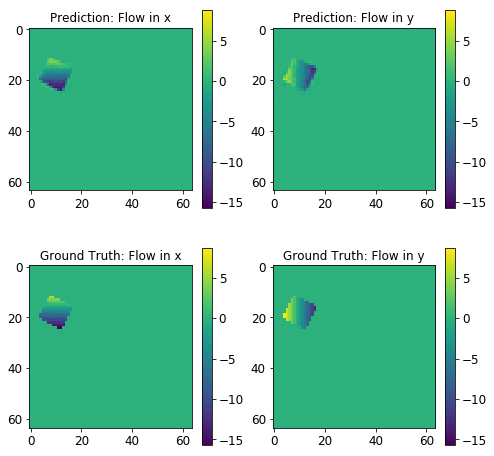

In [14]:
random_test_number = 101

test_example_images = np.expand_dims(test_in[random_test_number], axis=0)
test_example_gt = test_out[random_test_number]
test_example_pred = model.predict(test_example_images)
test_example_pred = np.squeeze(test_example_pred)
test_example_gt = np.squeeze(test_example_gt)

fl_min = np.min(test_example_gt)
fl_max = np.max(test_example_gt)
fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

fig, axes = plt.subplots(2, 2,figsize=(8,8))

print("Prediction and ground truth of the example images in the test set.")
im = axes[0, 0].imshow(test_example_pred[..., 0])
# im = axes[0, 0].imshow(test_example_pred[:len(test_example_pred)//2, :])
im.set_norm(fl_norm)
axes[0, 0].set_title('Prediction: Flow in x')
fig.colorbar(im,ax=axes[0, 0])

im = axes[0, 1].imshow(test_example_pred[..., 1])
# im = axes[0, 1].imshow(test_example_pred[len(test_example_pred)//2:, :])
im.set_norm(fl_norm)
axes[0, 1].set_title('Prediction: Flow in y')
fig.colorbar(im,ax=axes[0, 1])

im = axes[1, 0].imshow(test_example_gt[..., 0])
# im = axes[1, 0].imshow(test_example_gt[:len(test_example_gt)//2, ...])
im.set_norm(fl_norm)
axes[1, 0].set_title('Ground Truth: Flow in x')
fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(test_example_gt[..., 1])
# im = axes[1, 1].imshow(test_example_gt[len(test_example_gt)//2:, ...])
im.set_norm(fl_norm)
axes[1, 1].set_title('Ground Truth: Flow in y')
fig.colorbar(im,ax=axes[1, 1])

plt.show()

<a id='vgg16_transfer_learning'></a>

# 3. VGG16 transfer learning

<a id='get_all_data_sets'></a>

## 3.1 Get all data sets


In [15]:
mix_train_images = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'mix_images_train.npy'))
mix_train_flows = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'mix_flows_train.npy'))
mix_test_images = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'mix_images_test.npy'))
mix_test_flows = np.load(os.path.join(PROJECT_ROOT_DIR, NB_ID, 'mix_flows_test.npy'))

mix_train_in = GetInputSet(mix_train_images, concat_last_axis=True)
mix_train_out = GetOutputset(mix_train_flows, concat_last_axis=True)
mix_train_in, mix_train_out = Shuffle(mix_train_in, mix_train_out)

mix_test_in = GetInputSet(mix_test_images, concat_last_axis=True)
mix_test_out = GetOutputset(mix_test_flows, concat_last_axis=True)

rot_train_in = GetInputSet(train_images, concat_last_axis=True)
rot_train_out = GetOutputset(train_flows, concat_last_axis=True)
rot_train_in, rot_train_out = Shuffle(rot_train_in, rot_train_out)

rot_test_in = GetInputSet(test_images, concat_last_axis=True)
rot_test_out = GetOutputset(test_flows, concat_last_axis=True)

print("Shape of the rotation training images:\t", rot_train_in.shape)
print("Shape of the rotation training flows:\t",rot_train_out.shape)
print("Shape of the rotation test images:\t",rot_test_in.shape)
print("Shape of the rotation test flows:\t",rot_test_out.shape)

print("Shape of the mixed training images:\t", mix_train_in.shape)
print("Shape of the mixed training flows:\t",mix_train_out.shape)
print("Shape of the mixed test images:\t",mix_test_in.shape)
print("Shape of the mixed test flows:\t",mix_test_out.shape)

Shape of the rotation training images:	 (1860, 64, 64, 6)
Shape of the rotation training flows:	 (1860, 64, 64, 2)
Shape of the rotation test images:	 (444, 64, 64, 6)
Shape of the rotation test flows:	 (444, 64, 64, 2)
Shape of the mixed training images:	 (1860, 64, 64, 6)
Shape of the mixed training flows:	 (1860, 64, 64, 2)
Shape of the mixed test images:	 (444, 64, 64, 6)
Shape of the mixed test flows:	 (444, 64, 64, 2)


In [16]:
import tensorflow.keras.applications as App
K.clear_session()

base_model = App.vgg16.VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
vgg16_layers = Sequential()
for layer in base_model.layers[:14]:
    vgg16_layers.add(layer)

base_model.trainable = False
vgg16_layers.trainable = False
vgg16_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

In [17]:
header = L.Conv2D(64, (3, 3), strides=(1, 1), padding='same', \
                   activation='relu', input_shape=(64, 64, 6))
header2 = L.Conv2D(3, (3, 3), strides=(1, 1), padding='same', \
                   activation='relu')

regression_layer1 = L.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer2 = L.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer3 = L.Conv2DTranspose(128 , (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer4 = L.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer5 = L.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer6 = L.Conv2D(1, (3, 3), strides=(1, 1), padding='same', \
                   activation='linear')
regression_layer7 = L.Conv2DTranspose(2, (3, 3), strides=(1, 1), padding='same', \
                   activation='linear')

vgg16_based_model = Sequential([header, header2, vgg16_layers, regression_layer2,
                                regression_layer3, regression_layer4, regression_layer7])

vgg16_based_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3520      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         1731      
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 512)         7635264   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 64)        73792     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 2)         1154      
Total para

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=1, min_lr=1e-5)

vgg16_based_model.compile(loss=Loss, optimizer=Adam(lr=0.0003), metrics=[Metrics])
vgg16_based_model.fit(rot_train_in, rot_train_out, batch_size=10, epochs=10,
#             validation_data=(test_in, test_out),
            callbacks=[reduce_lr])

Epoch 1/10
1860/1860 [==============================] - 8s 4ms/step - loss: 0.4548 - Metrics: 0.0953
Epoch 2/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.2611 - Metrics: 0.2223
Epoch 3/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.2305 - Metrics: 0.2496
Epoch 4/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.2059 - Metrics: 0.2831
Epoch 5/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.1838 - Metrics: 0.3114
Epoch 6/10
1860/1860 [==============================] - 6s 3ms/step - loss: 0.1609 - Metrics: 0.3250
Epoch 7/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.1454 - Metrics: 0.3286
Epoch 8/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.1307 - Metrics: 0.3494
Epoch 9/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.1209 - Metrics: 0.3584
Epoch 10/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.1133 - Metri

In [19]:
random_test_number = 101

rot_test_example_images = np.expand_dims(rot_test_in[random_test_number], axis=0)
rot_test_example_gt = rot_test_out[random_test_number]
rot_test_example_pred = vgg16_based_model.predict(rot_test_example_images)
rot_test_example_pred = np.squeeze(rot_test_example_pred)
rot_test_example_gt = np.squeeze(rot_test_example_gt)

rot_fl_min = np.min(rot_test_example_gt)
rot_fl_max = np.max(rot_test_example_gt)
rot_fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

vgg16_based_model.evaluate(rot_test_in, rot_test_out)

444/444 [==============================] - 1s 3ms/step


[0.1407922286171097, 0.3877041098233816]

In [20]:
K.clear_session()

base_model = App.vgg16.VGG16(input_shape=(128, 64, 3), include_top=False, weights='imagenet')
vgg16_layers = Sequential()
for layer in base_model.layers[:14]:
    vgg16_layers.add(layer)

base_model.trainable = False
vgg16_layers.trainable = False

header = L.Conv2D(64, (3, 3), strides=(1, 1), padding='same', \
                   activation='relu', input_shape=(64, 64, 6))
header2 = L.Conv2D(3, (3, 3), strides=(1, 1), padding='same', \
                   activation='relu')

regression_layer1 = L.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer2 = L.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer3 = L.Conv2DTranspose(128 , (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer4 = L.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer5 = L.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', \
                   activation='relu')
regression_layer6 = L.Conv2D(1, (3, 3), strides=(1, 1), padding='same', \
                   activation='linear')
regression_layer7 = L.Conv2DTranspose(2, (3, 3), strides=(1, 1), padding='same', \
                   activation='linear')

vgg16_based_model = Sequential([header, header2, vgg16_layers, regression_layer2,
                                regression_layer3, regression_layer4, regression_layer7])

vgg16_based_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3520      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         1731      
_________________________________________________________________
sequential (Sequential)      multiple                  7635264   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 64)        73792     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 2)         1154      
Total para

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=1, min_lr=1e-5)

vgg16_based_model.compile(loss=Loss, optimizer=Adam(lr=0.0003), metrics=[Metrics])
vgg16_based_model.fit(mix_train_in, mix_train_out, batch_size=10, epochs=10,
#             validation_data=(test_in, test_out),
            callbacks=[reduce_lr])

Epoch 1/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.6220 - Metrics: 0.2028
Epoch 2/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.6217 - Metrics: 0.2302
Epoch 3/10
1860/1860 [==============================] - 6s 3ms/step - loss: 0.6217 - Metrics: 0.2492
Epoch 4/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.6217 - Metrics: 0.2475
Epoch 5/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.6216 - Metrics: 0.2454
Epoch 6/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.5509 - Metrics: 0.1487
Epoch 7/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.3140 - Metrics: 0.2641
Epoch 8/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.2549 - Metrics: 0.3601
Epoch 9/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.2232 - Metrics: 0.6325
Epoch 10/10
1860/1860 [==============================] - 7s 4ms/step - loss: 0.2039 - Metri

In [22]:
mix_test_example_images = np.expand_dims(mix_test_in[random_test_number], axis=0)
mix_test_example_gt = mix_test_out[random_test_number]
mix_test_example_pred = vgg16_based_model.predict(mix_test_example_images)
mix_test_example_pred = np.squeeze(mix_test_example_pred)
mix_test_example_gt = np.squeeze(mix_test_example_gt)

mix_fl_min = np.min(mix_test_example_gt)
mix_fl_max = np.max(mix_test_example_gt)
mix_fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

vgg16_based_model.evaluate(mix_test_in, mix_test_out)

444/444 [==============================] - 1s 1ms/step


[0.22147919157066862, 0.8751388423077695]

Prediction and ground truth of the example images in the test set.


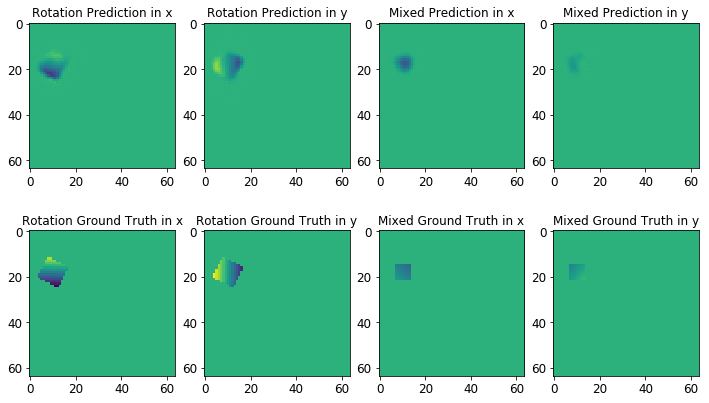

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(12,7))

print("Prediction and ground truth of the example images in the test set.")
im = axes[0, 0].imshow(rot_test_example_pred[..., 0])
im.set_norm(rot_fl_norm)
axes[0, 0].set_title('Rotation Prediction in x')
# fig.colorbar(im,ax=axes[0, 0])

im = axes[0, 1].imshow(rot_test_example_pred[..., 1])
im.set_norm(rot_fl_norm)
axes[0, 1].set_title('Rotation Prediction in y')
# fig.colorbar(im,ax=axes[0, 1])

im = axes[1, 0].imshow(rot_test_example_gt[..., 0])
im.set_norm(rot_fl_norm)
axes[1, 0].set_title('Rotation Ground Truth in x')
# fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(rot_test_example_gt[..., 1])
im.set_norm(rot_fl_norm)
axes[1, 1].set_title('Rotation Ground Truth in y')
# fig.colorbar(im,ax=axes[1, 1])

#############################################################
im = axes[0, 2].imshow(mix_test_example_pred[..., 0])
im.set_norm(mix_fl_norm)
axes[0, 2].set_title('Mixed Prediction in x')
# fig.colorbar(im,ax=axes[0, 2])

im = axes[0, 3].imshow(mix_test_example_pred[..., 1])
im.set_norm(mix_fl_norm)
axes[0, 3].set_title('Mixed Prediction in y')
# fig.colorbar(im,ax=axes[0, 3])

im = axes[1, 2].imshow(mix_test_example_gt[..., 0])
im.set_norm(mix_fl_norm)
axes[1, 2].set_title('Mixed Ground Truth in x')
# fig.colorbar(im,ax=axes[1, 2])

im = axes[1, 3].imshow(mix_test_example_gt[..., 1])
im.set_norm(mix_fl_norm)
axes[1, 3].set_title('Mixed Ground Truth in y')
# fig.colorbar(im,ax=axes[1, 3])

plt.show()

In [24]:
from tensorflow.keras.models import Model

K.clear_session()

def FirstTwoLayers(x):
    x = L.Conv2D(64, (3, 3), strides=(2, 2), padding='same', \
                               activation='relu')(x)
    x = L.Conv2D(128, (3, 3), strides=(2, 2), padding='same', \
                               activation='relu')(x)
    return x

def NonSeqModel(input_start, input_goal):
    feature_start = FirstTwoLayers(input_start)
    feature_goal = FirstTwoLayers(input_goal)

    x = L.Concatenate()([feature_start, feature_goal])
    x = L.Conv2D(256, (3, 3), strides=(1, 1), padding='same', \
                       activation='relu')(x)
    x = L.Conv2D(512, (3, 3), strides=(1, 1), padding='same', \
                       activation='relu')(x)
    x = L.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', \
                       activation='relu')(x)
    x = L.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', \
                       activation='relu')(x)
    x = L.Conv2D(2, (3, 3), strides=(1, 1), padding='same', \
                       activation='linear')(x)
    return Model(inputs=[input_start, input_goal], outputs=x)


model_input_start = L.Input(shape=(64,64,3))
model_input_goal = L.Input(shape=(64,64,3))

nonseqentialModel = NonSeqModel(model_input_start, model_input_goal)
nonseqentialModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

In [25]:
def TransferInputData(input_data):
    """
    Function: transfer training data to the format we want.
    """
    return [input_data[..., :3], input_data[..., 3:]]

rot_train_in_sep = TransferInputData(rot_train_in)
rot_test_in_sep = TransferInputData(rot_test_in)

In [26]:
# GPU memory management
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, min_lr=1e-5)

nonseqentialModel.compile(loss=Loss, optimizer=Adam(lr=0.0008), metrics=[Metrics])

nonseqentialModel.fit(rot_train_in_sep, rot_train_out, batch_size=10, epochs=10,
#             validation_data=(test_in, test_out),
            callbacks=[reduce_lr])

Epoch 1/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.3802 - Metrics: 0.2758
Epoch 2/10
1860/1860 [==============================] - 8s 5ms/step - loss: 0.1566 - Metrics: 0.2051
Epoch 3/10
1860/1860 [==============================] - 8s 4ms/step - loss: 0.1020 - Metrics: 0.1951
Epoch 4/10
1860/1860 [==============================] - 8s 4ms/step - loss: 0.0686 - Metrics: 0.1527
Epoch 5/10
1860/1860 [==============================] - 8s 4ms/step - loss: 0.0519 - Metrics: 0.1939
Epoch 6/10
1860/1860 [==============================] - 8s 4ms/step - loss: 0.0427 - Metrics: 0.2407
Epoch 7/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0336 - Metrics: 0.3030
Epoch 8/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0294 - Metrics: 0.3108
Epoch 9/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0306 - Metrics: 0.3425
Epoch 10/10
1860/1860 [==============================] - 9s 5ms/step - loss: 0.0197 - Metri

In [27]:
nonseqentialModel.evaluate(rot_test_in_sep, rot_test_out)

444/444 [==============================] - 1s 2ms/step


[0.022587707232650335, 0.535259076603898]

Prediction and ground truth of the example images in the test set.


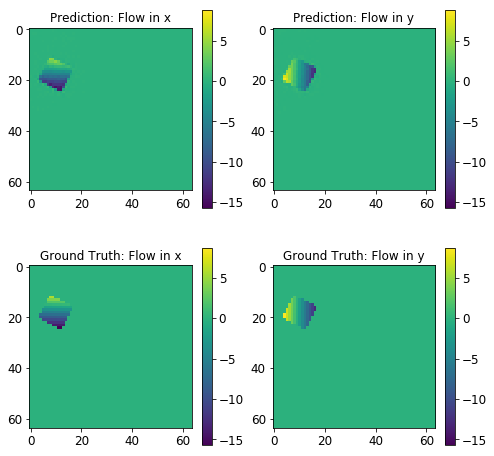

In [28]:
random_test_number = 101

test_example_images_1 = np.expand_dims(rot_test_in_sep[0][random_test_number], axis=0)
test_example_images_2 = np.expand_dims(rot_test_in_sep[1][random_test_number], axis=0)
test_example_images = [test_example_images_1, test_example_images_2]
test_example_gt = rot_test_out[random_test_number]
test_example_pred = nonseqentialModel.predict(test_example_images)
test_example_pred = np.squeeze(test_example_pred)
test_example_gt = np.squeeze(test_example_gt)

fl_min = np.min(test_example_gt)
fl_max = np.max(test_example_gt)
fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

fig, axes = plt.subplots(2, 2,figsize=(8,8))

print("Prediction and ground truth of the example images in the test set.")
im = axes[0, 0].imshow(test_example_pred[..., 0])
im.set_norm(fl_norm)
axes[0, 0].set_title('Prediction: Flow in x')
fig.colorbar(im,ax=axes[0, 0])

im = axes[0, 1].imshow(test_example_pred[..., 1])
im.set_norm(fl_norm)
axes[0, 1].set_title('Prediction: Flow in y')
fig.colorbar(im,ax=axes[0, 1])

im = axes[1, 0].imshow(test_example_gt[..., 0])
im.set_norm(fl_norm)
axes[1, 0].set_title('Ground Truth: Flow in x')
fig.colorbar(im,ax=axes[1, 0])

im = axes[1, 1].imshow(test_example_gt[..., 1])
# im = axes[1, 1].imshow(test_example_gt[len(test_example_gt)//2:, ...])
im.set_norm(fl_norm)
axes[1, 1].set_title('Ground Truth: Flow in y')
fig.colorbar(im,ax=axes[1, 1])

plt.show()